# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.color_palette('pastel')

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
#azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
for value in feat_info['missing_or_unknown']:
    print(value, type(value))

[-1,0] <class 'str'>
[-1,0,9] <class 'str'>
[-1,0] <class 'str'>
[0] <class 'str'>
[-1] <class 'str'>
[-1] <class 'str'>
[-1] <class 'str'>
[-1] <class 'str'>
[-1] <class 'str'>
[-1] <class 'str'>
[-1] <class 'str'>
[0] <class 'str'>
[] <class 'str'>
[] <class 'str'>
[-1,0] <class 'str'>
[0] <class 'str'>
[0] <class 'str'>
[0] <class 'str'>
[0] <class 'str'>
[0] <class 'str'>
[0] <class 'str'>
[-1,0] <class 'str'>
[-1,0] <class 'str'>
[0] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1,9] <class 'str'>
[-1] <class 'str'>
[-1] <class 'str'>
[-1,0] <class 'str'>
[-1] <class 'str'>
[-1,9] <class 'str'>
[0] <class 'str'>
[] <class 'str'>
[] <class 'str'>
[-1,0] <class 'str'>
[-1] <class 'str'>
[-1,0] <class 'str'>
[-1,0] <class 'str'>
[0] <class 'str'

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
def str_to_list(value):
    return value.strip("[]").replace(" ", "").split(",")

#reimporting the feat_info data frame, now using the converters arguments in the pd.read_csv()
feat_info = pd.read_csv("./AZDIAS_Feature_Summary.csv", sep=";", converters={"missing_or_unknown": str_to_list})

for value in feat_info["missing_or_unknown"]:
    print(value, type(value))

['-1', '0'] <class 'list'>
['-1', '0', '9'] <class 'list'>
['-1', '0'] <class 'list'>
['0'] <class 'list'>
['-1'] <class 'list'>
['-1'] <class 'list'>
['-1'] <class 'list'>
['-1'] <class 'list'>
['-1'] <class 'list'>
['-1'] <class 'list'>
['-1'] <class 'list'>
['0'] <class 'list'>
[''] <class 'list'>
[''] <class 'list'>
['-1', '0'] <class 'list'>
['0'] <class 'list'>
['0'] <class 'list'>
['0'] <class 'list'>
['0'] <class 'list'>
['0'] <class 'list'>
['0'] <class 'list'>
['-1', '0'] <class 'list'>
['-1', '0'] <class 'list'>
['0'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1', '9'] <class 'list'>
['-1'] <class 'list'>
['-1'] <class 'list'>
['-1', '0'] <class 'list'>
[

In [6]:
##Now replace the missing values in the azdias data frame

na_mapping = dict(zip(feat_info["attribute"], 
                      feat_info["missing_or_unknown"]))

print(na_mapping)

{'AGER_TYP': ['-1', '0'], 'ALTERSKATEGORIE_GROB': ['-1', '0', '9'], 'ANREDE_KZ': ['-1', '0'], 'CJT_GESAMTTYP': ['0'], 'FINANZ_MINIMALIST': ['-1'], 'FINANZ_SPARER': ['-1'], 'FINANZ_VORSORGER': ['-1'], 'FINANZ_ANLEGER': ['-1'], 'FINANZ_UNAUFFAELLIGER': ['-1'], 'FINANZ_HAUSBAUER': ['-1'], 'FINANZTYP': ['-1'], 'GEBURTSJAHR': ['0'], 'GFK_URLAUBERTYP': [''], 'GREEN_AVANTGARDE': [''], 'HEALTH_TYP': ['-1', '0'], 'LP_LEBENSPHASE_FEIN': ['0'], 'LP_LEBENSPHASE_GROB': ['0'], 'LP_FAMILIE_FEIN': ['0'], 'LP_FAMILIE_GROB': ['0'], 'LP_STATUS_FEIN': ['0'], 'LP_STATUS_GROB': ['0'], 'NATIONALITAET_KZ': ['-1', '0'], 'PRAEGENDE_JUGENDJAHRE': ['-1', '0'], 'RETOURTYP_BK_S': ['0'], 'SEMIO_SOZ': ['-1', '9'], 'SEMIO_FAM': ['-1', '9'], 'SEMIO_REL': ['-1', '9'], 'SEMIO_MAT': ['-1', '9'], 'SEMIO_VERT': ['-1', '9'], 'SEMIO_LUST': ['-1', '9'], 'SEMIO_ERL': ['-1', '9'], 'SEMIO_KULT': ['-1', '9'], 'SEMIO_RAT': ['-1', '9'], 'SEMIO_KRIT': ['-1', '9'], 'SEMIO_DOM': ['-1', '9'], 'SEMIO_KAEM': ['-1', '9'], 'SEMIO_PFLICHT': 

In [7]:
#Reloading the azdias data frame using the na_values argument
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', 
                     na_values=na_mapping)

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Text(0.5,1,'Count of missing values in the columns')

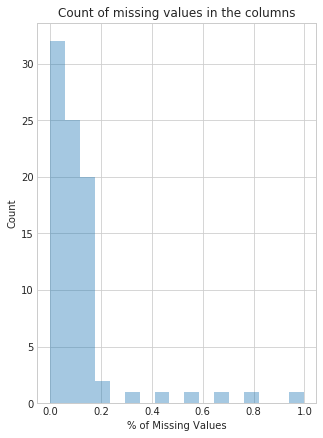

In [8]:
#Looking at the missing values in each column
col_missing_values = azdias.isnull().mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(5,7))
sns.distplot(col_missing_values, hist=True, kde=False)
ax.set_xlabel('% of Missing Values')
ax.set_ylabel('Count')
ax.set_title('Count of missing values in the columns')

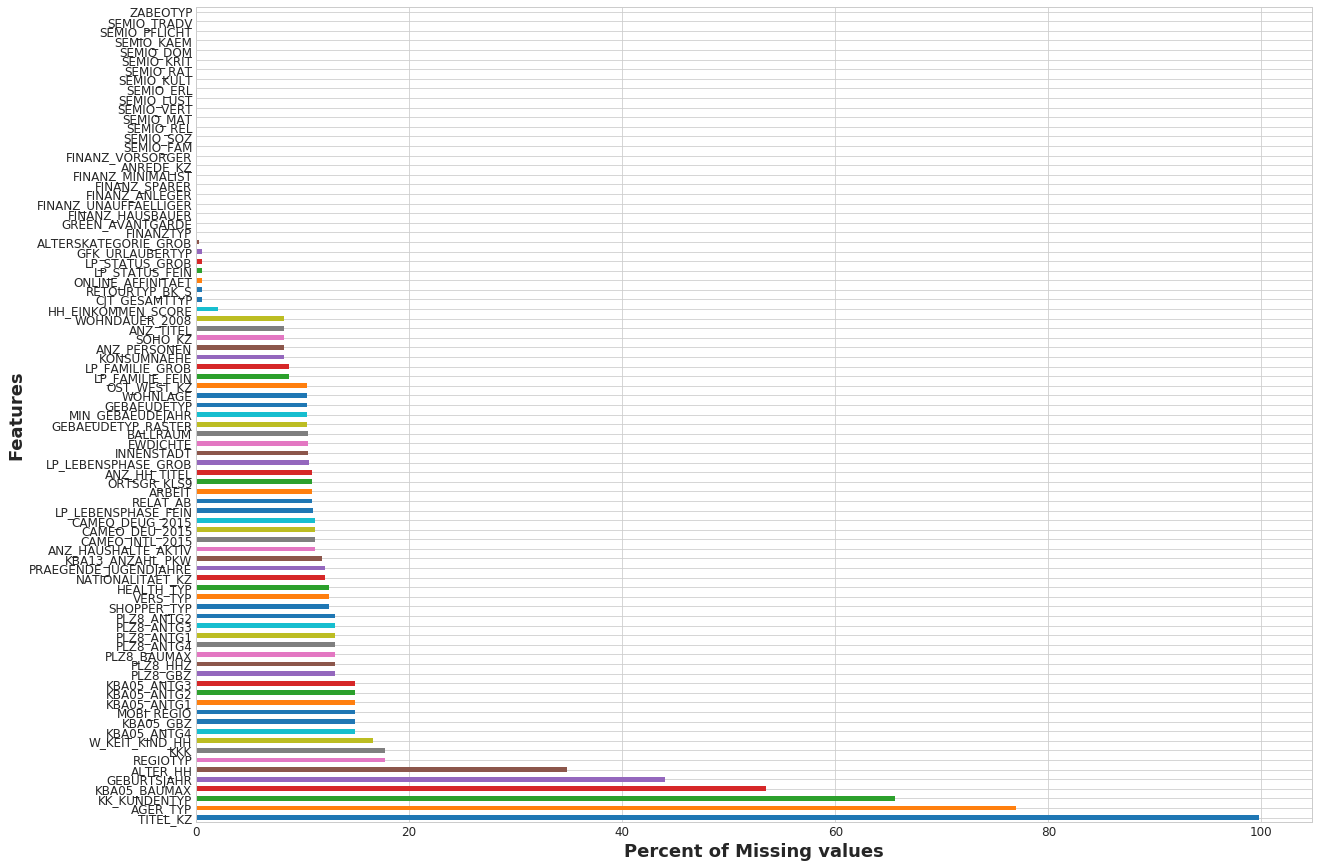

In [9]:
# Investigate patterns in the amount of missing data in each column.
col_missing_values = azdias.isnull().mean().sort_values(ascending=False)*100

fig, ax = plt.subplots()
ax = col_missing_values.plot(kind='barh', figsize=(20,15))
ax.set_xlabel('Percent of Missing values', size=18, fontweight='bold')
ax.set_ylabel('Features', size=18, fontweight='bold')
ax.tick_params(axis='both', labelsize=12)

In [10]:
#import sys
#!{sys.executable} -m pip install missingno

#import missingno as msno

In [11]:
#msno.matrix(azdias)

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

"""PERSONAL COMMENT: As first approach, I will arbitrarily choose to remove columns with 
20% or more of missing data"""
#Since there were so few columns I just copied and pasted, 
#rather than writing code to select the columns
cols_over20 = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP',
                   'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']

azdias_col_cleaned = azdias.drop(columns=cols_over20, axis='columns')

#### Discussion 1.1.2: Assess Missing Data in Each Column
Amount of missing data: As we can be seen visually from the horizontal bar chart, there are a substantial number of features that have missing data. On the chart, 6 features have over 20% of missing data which to my mind is considered high.

Are there any patterns in missing values: As a visual inspection at the feat_info data frame, we can see that values such as -1, 0 and 9 were quite comon as missing values. Additinally, as we can see from the missingno.matrix chart, we can see that missing some missing values are highly correlated between observations. For instance, if a persons's weight is was not measured, then there's a high probability that that a feature such as BMI will also be missing.

Which columns were removed from the dataset: Some features had too many missing values and were removed. As mentioned above, features with more than 20% of missing values were removed, 6 in total.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5,1,'Count of missing values in the rows')

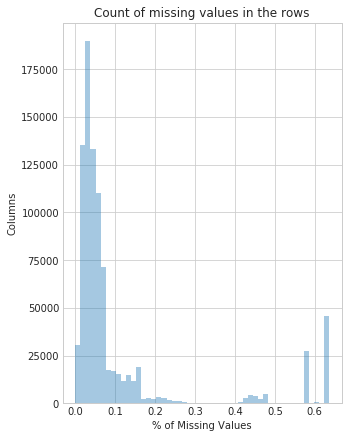

In [13]:
# How much data is missing in each row of the dataset?
row_missing_values = azdias.isnull().mean(axis=1).sort_values(ascending=False)

#Plotting to see the percentage of missing values in rows. 
fig, ax = plt.subplots(figsize=(5,7))
sns.distplot(row_missing_values, hist=True, kde=False)
ax.set_xlabel('% of Missing Values')
ax.set_ylabel('Columns')
ax.set_title('Count of missing values in the rows')

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
"""I'm going to create a column in the azdias data frame with the of missing values per row.
Then I'll create an adjacent columns classifying the row as having low or high missing values, 
that way it might be easier to separate the data set to groups"""

azdias['%_null_rows'] = azdias.isnull().mean(axis=1)*100

def map_high_low(x):
    if x>20:
        return('High Missing Values')
    else:
        return('Low Missing Values')

azdias['class_null_values'] = azdias['%_null_rows'].map(map_high_low)

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,%_null_rows,class_null_values
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.647059,High Missing Values
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,4.705882,Low Missing Values
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,4.705882,Low Missing Values
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,10.588235,Low Missing Values
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,3.529412,Low Missing Values


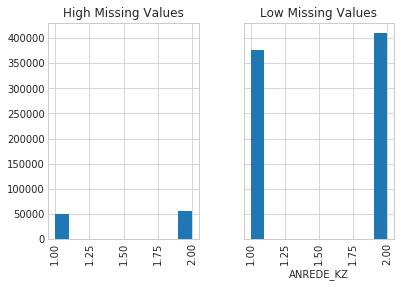

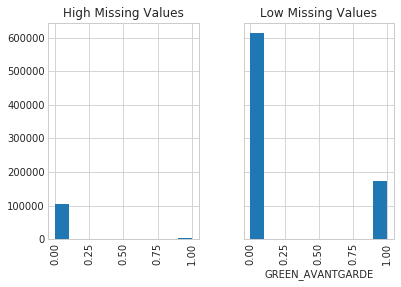

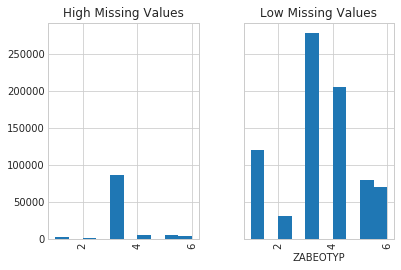

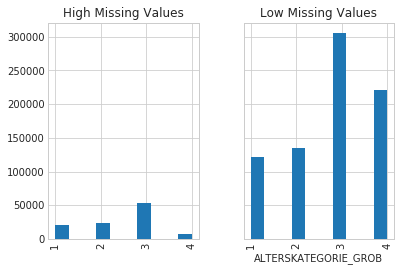

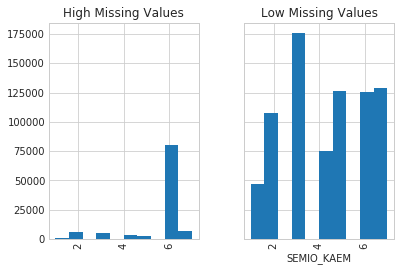

In [15]:
#These are the five columns chosen to evaluate
list = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'ZABEOTYP', 
        'ALTERSKATEGORIE_GROB', 'SEMIO_KAEM']


for x in list:
    azdias[x].hist(by=azdias['class_null_values'], sharey=True)
    plt.xlabel(str(x))
    plt.ylabel('Count')
    plt.show()

In [16]:
# Drop rows with high missing values
azdias_row_cleaned = azdias[azdias['class_null_values']=='Low Missing Values']

#Now I will remove the columuns with high missing values from the azdias_row_cleaned
#with the addition of the created columns %_null_rows', 'class_null_values'

cols_remove = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP',
                   'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH',
               '%_null_rows', 'class_null_values' ]

azdias_cleaned = azdias_row_cleaned.drop(columns=cols_remove, axis='columns')


print('A total of {} rows were removed after cleaning'.format(azdias.shape[0]- azdias_cleaned.shape[0]))
print('representing approximately {:.2f}% of rows'.format(((azdias.shape[0]- azdias_cleaned.shape[0])/azdias.shape[0])*100))


A total of 105460 rows were removed after cleaning
representing approximately 11.83% of rows


In [17]:
#Visual sanity check for how the data frame looks like afeter being cleaned.
#msno.matrix(azdias_cleaned)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Are the data with lots of missing values are qualitatively different from data with few or no missing values?

As can be seen from the several histrograms plotted there is no significant difference between the distribution of the two subset (high and low missing values in rows), which give good confidence to remove the rows considered having high missing values.

Lastly, we can compare between the matrix prlo in line 29 (no cleaning) and line 47 (both columns and rows cleaned) it looks like even though there are some patches of missing values, the data does look cleaner; and as a first a approach it looks like we can live with the missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [18]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

In [19]:
cat_cols = feat_info[feat_info['type']=='categorical']
cat_cols

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


In [20]:
#removing the columns that have been dropped the in the previous step because 
#the were considered having too many missing values.
feat_info_cleaned = cat_cols.drop(index=[40, 0,47], axis=1)
cat_feats = feat_info_cleaned['attribute'].values
#numpy array with the categorical values to be further investigated
cat_feats

array(['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP',
       'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [21]:
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1, 0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1, XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1, 0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1, 0]"


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary_cats=[]
multilevel_cats=[]
def count_cats(df, cols):
    for x in cols:
        if df[x].nunique() == 2:
            binary_cats.append(x)
        if df[x].nunique() > 2:
            multilevel_cats.append(x)
            
count_cats(azdias_cleaned,cat_feats)

print('{} features are binary categorical features'.format(len(binary_cats)))
print('{} features are multilevel categorical features'.format(len(multilevel_cats)))


5 features are binary categorical features
13 features are multilevel categorical features


In [23]:
multilevel_cats

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [24]:
azdias_cleaned.shape

(785761, 79)

In [25]:
"""PERSONAL COMMENT: In the interest of keeping a first model as much simple as possible,
I'll' remove the 13 categorical features that are multilevel."""

azdias_cleaned_binary = azdias_cleaned.drop(columns=['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015'], axis='columns')

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
"""PERSONAL COMMENT: I'm going to give the binary encoded variable a prefix CAT-BIN,
so that it is easier to track if necessary later on."""
azdias_cleaned_binary_encoded = pd.get_dummies(azdias_cleaned_binary, 
                                               columns=['ANREDE_KZ', 'GREEN_AVANTGARDE', 
                                                'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'],
                                              prefix='CAT-BIN')
azdias_cleaned_binary_encoded.shape

(785761, 71)

#### Discussion 1.2.1: Re-Encode Categorical Features

The following categorical features were dropped from the data set because they contained more the 2 categories. 
['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

For the sake of simplicity of the first approach, only the binary categorical variables were carried and re-encoded accordingly using the get_dummies from pandas. After dimensionality reduction it is possible I might go back and incorporate the multilevel features to see if there are any differences. But at this stage, leaving them out sounds like a good approach.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#based on decade
dict_generation = {1:1,2:1,
                   3:2,4:2,
                   5:3,6:3,7:3,
                   8:4,9:4,
                   10:5,11:5,12:5,13:5,
                   14:6,15:6}

#Engineering the decade feature, 1st new feature
azdias_cleaned_binary_encoded['PRAEGENDE_JUGENDJAHRE_decade']=azdias_cleaned_binary_encoded['PRAEGENDE_JUGENDJAHRE'].map(dict_generation)


In [28]:
#Engineering 2nd Feature fo the "PRAEGENDE_JUGENDJAHRE"
#1 = Mainstream
#2 = Avantgarde
dict_culture = {1:1, 2:2,
                   3:1,4:2,
                   5:1,6:2,7:2,
                   8:1,9:2,
                   10:1,11:2,12:1,13:2,
                   14:1,15:2}

azdias_cleaned_binary_encoded['PRAEGENDE_JUGENDJAHRE_Culture']=azdias_cleaned_binary_encoded['PRAEGENDE_JUGENDJAHRE'].map(dict_culture)


In [29]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_cleaned_binary_encoded['CAMEO_INTL_2015'].dtypes

"""PERSONAL COMMENT: "CAMEO_INTL_2015" still as object"""

'PERSONAL COMMENT: "CAMEO_INTL_2015" still as object'

In [30]:
#Converting "CAMEO_INTL_2015" to float64 so that re-engineering is possible
azdias_cleaned_binary_encoded['CAMEO_INTL_2015']=azdias_cleaned_binary_encoded['CAMEO_INTL_2015'].astype('float64')

In [31]:
#Creating first CAMEO_INTL_2015 feature: Social Strata

#1 = Wealthy households
#2 = Prosperous Household
#3 = Comfortable Households
#4 = Less Affluent Households
#5 = Poorer Households
dict_social_strat = {11:1,12:1,13:1,14:1,15:1,
                     21:2,22:2,23:2,24:2,25:2,
                     31:3,32:3,33:3,34:3,35:3,
                     41:4,42:4,43:4,44:4,45:4,
                     51:5,52:5,53:5,54:5,55:5}
azdias_cleaned_binary_encoded['CAMEO_INTL_2015_social_strat']=azdias_cleaned_binary_encoded['CAMEO_INTL_2015'].map(dict_social_strat)

In [32]:
#Creating second CAMEO_INTL_2015 feature: Family Structure

#1 = Pre-Family Couples & Singles
#2 = Young Couples With Children
#3 = Families With School Age Children
#4 = Older Families & Mature Couples
#5 = Elders In Retirement
dict_Family_Stuc = {11:1,12:2,13:3,14:4,15:5,
                     21:1,22:2,23:3,24:4,25:5,
                     31:1,32:2,33:3,34:4,35:5,
                     41:1,42:2,43:3,44:4,45:5,
                     51:1,52:2,53:3,54:4,55:45}
azdias_cleaned_binary_encoded['CAMEO_INTL_2015_Family_Struc']=azdias_cleaned_binary_encoded['CAMEO_INTL_2015'].map(dict_Family_Stuc)

In [33]:
#Further investigation of mixed value features
mixed_features = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB',
                  'WOHNLAGE', 'PLZ8_BAUMAX']

#Finding the number of unique values in each of the
number_MixedFeatures = []
for i in mixed_features:
    n = azdias_cleaned_binary_encoded[i].nunique()
    number_MixedFeatures.append(n)

mixed_features_dict = dict(zip(mixed_features,number_MixedFeatures))

mixed_features_dict

{'LP_LEBENSPHASE_FEIN': 40,
 'LP_LEBENSPHASE_GROB': 12,
 'WOHNLAGE': 8,
 'PLZ8_BAUMAX': 5}

#### Discussion 1.2.2: Engineer Mixed-Type Features

In the mixed-type features such as PRAEGENDE_JUGENDJAHRE there is definitely the option of re-engineering the feature in to another two separate variables. The first is based on the decade/generation in which each individual lived thorough., reducing the original 15 categories to 5. The second feature was based on the cultural style one wishes to experience, i.e. mainstream or avantgarde.

Two other features were re-engineered for the CAMEO_INTL_2015. The first was re-engineered to reflect the social strata of the individual’s household based on wealth. Five categories were established: Wealthy, prosperous, comfortable, less affluent, poorer. The second feature was re-engineered to reflect the family structure of the individuals based on age of the couples. Five categories were established: pre-family couples & singles, young couples with children, families with school age children, older families & mature couples, elders in retirement.

As for the remainder of the mixed-type features, I’ll make the decision to carry on the PLZ8_BAUMAX and WOHNLAGE since they do not contain a large number of categories they seem rather straight forward. I have, however, chosen to remove the following features: LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB. The categories within these features seem rather sizable and complex even if a couple of new features could be advocated. However, at this junction I feel that this might introduce further complexity to the model and I do want to keep complexity to a minimum on the first approache. In a future iteration, I might go back and see if re-engineering these two features might help the model if needed. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
#Removing the categorical 
azdias_cleaned_binary_encoded.drop(columns=['PRAEGENDE_JUGENDJAHRE', 
'CAMEO_INTL_2015', 
'LP_LEBENSPHASE_FEIN', 
'LP_LEBENSPHASE_GROB'], axis='columns', inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [36]:
#def clean_data(df):
"""
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
"""
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

'\n    Perform feature trimming, re-encoding, and engineering for demographics\n    data\n    \n    INPUT: Demographics DataFrame\n    OUTPUT: Trimmed and cleaned demographics DataFrame\n'

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
"""PESONAL COMMNENT: First, before we carry out any feature scaling, deleting, or imputing 
of the NaNs, I'll first look at how the numeric features are distributed, i.e. the continuous 
features. For instance, this will give a good clue if we should impute 
with mean or mode. Remembering that the column 'GEBURTSJAHR' was already 
dropped at the begining for having over 20% of missing values."""

"PESONAL COMMNENT: First, before we carry out any feature scaling, deleting, or imputing \nof the NaNs, I'll first look at how the numeric features are distributed, i.e. the continuous \nfeatures. For instance, this will give a good clue if we should impute \nwith mean or mode. Remembering that the column 'GEBURTSJAHR' was already \ndropped at the begining for having over 20% of missing values."

In [38]:
feat_info[feat_info['type']=='numeric']
#feat_info['type'].value_counts()

,attribute,information_level,type,missing_or_unknown
11,GEBURTSJAHR,person,numeric,[0]
44,ANZ_PERSONEN,household,numeric,[]
45,ANZ_TITEL,household,numeric,[]
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]
51,ANZ_HH_TITEL,building,numeric,[]
54,MIN_GEBAEUDEJAHR,building,numeric,[0]
74,KBA13_ANZAHL_PKW,macrocell_plz8,numeric,[]


In [39]:
"""PERSONAL COMMNET: As we can see there are significant differences
of the variances in the numeric features. I'm going to investigate the features a little further"""
azdias_cleaned_binary_encoded[['ANZ_PERSONEN', 'ANZ_TITEL',
                 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
                  'MIN_GEBAEUDEJAHR', 'KBA13_ANZAHL_PKW']].var()

ANZ_PERSONEN                1.342460
ANZ_TITEL                   0.004681
ANZ_HAUSHALTE_AKTIV       247.831947
ANZ_HH_TITEL                0.105699
MIN_GEBAEUDEJAHR            7.474236
KBA13_ANZAHL_PKW       115348.458653
dtype: float64

In [40]:
#Taking a look at the ANZ_PERSONEN feature
azdias_cleaned_binary_encoded['ANZ_PERSONEN'].max(), azdias_cleaned_binary_encoded['ANZ_PERSONEN'].min()

(45.0, 0.0)

In [41]:
azdias_cleaned_binary_encoded['ANZ_PERSONEN'].value_counts()/azdias_cleaned_binary_encoded.shape[0]

1.0     0.517601
2.0     0.238422
3.0     0.116775
4.0     0.058118
0.0     0.040945
5.0     0.019172
6.0     0.005998
7.0     0.001894
8.0     0.000650
9.0     0.000223
10.0    0.000083
11.0    0.000047
12.0    0.000020
13.0    0.000014
14.0    0.000005
21.0    0.000005
15.0    0.000004
20.0    0.000004
22.0    0.000003
38.0    0.000003
37.0    0.000003
23.0    0.000003
17.0    0.000001
40.0    0.000001
18.0    0.000001
45.0    0.000001
16.0    0.000001
35.0    0.000001
31.0    0.000001
Name: ANZ_PERSONEN, dtype: float64

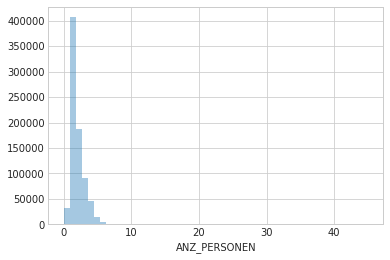

In [42]:
sns.distplot(azdias_cleaned_binary_encoded['ANZ_PERSONEN'], 
             hist=True, kde=False)
plt.xlim()
plt.show()

In [43]:
#Investigating the ANZ_TITEL
azdias_cleaned_binary_encoded['ANZ_TITEL'].max(), azdias_cleaned_binary_encoded['ANZ_TITEL'].min()

(4.0, 0.0)

In [44]:
azdias_cleaned_binary_encoded['ANZ_TITEL'].value_counts()/azdias_cleaned_binary_encoded.shape[0]

0.0    0.996112
1.0    0.003639
2.0    0.000241
3.0    0.000006
4.0    0.000003
Name: ANZ_TITEL, dtype: float64

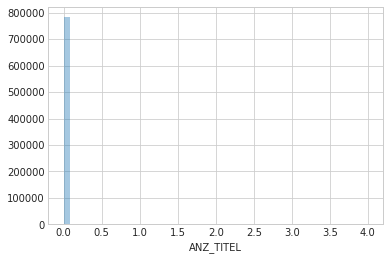

In [45]:
sns.distplot(azdias_cleaned_binary_encoded['ANZ_TITEL'], hist=True, kde=False)
plt.xlim()
plt.show()

In [46]:
azdias_cleaned_binary_encoded['ANZ_HAUSHALTE_AKTIV'].value_counts()/azdias_cleaned_binary_encoded.shape[0]

1.0      0.241421
2.0      0.151704
3.0      0.078832
4.0      0.054471
5.0      0.047625
6.0      0.045388
7.0      0.043587
8.0      0.040776
9.0      0.036664
10.0     0.032119
11.0     0.027801
12.0     0.022788
13.0     0.019324
14.0     0.015976
15.0     0.013118
16.0     0.011238
17.0     0.009215
18.0     0.007990
19.0     0.006894
20.0     0.005905
21.0     0.005227
22.0     0.004739
23.0     0.004094
24.0     0.003570
25.0     0.003319
26.0     0.002963
27.0     0.002824
28.0     0.002577
29.0     0.002478
30.0     0.002303
           ...   
326.0    0.000005
250.0    0.000005
266.0    0.000005
174.0    0.000005
260.0    0.000005
256.0    0.000005
523.0    0.000005
255.0    0.000005
301.0    0.000005
249.0    0.000005
515.0    0.000005
285.0    0.000005
293.0    0.000004
224.0    0.000004
414.0    0.000004
168.0    0.000004
272.0    0.000004
395.0    0.000004
307.0    0.000004
244.0    0.000004
226.0    0.000004
378.0    0.000004
404.0    0.000003
237.0    0.000003
254.0    0

In [47]:
#sns.distplot(azdias_cleaned_binary_encoded['ANZ_HH_TITEL'], hist=True, kde=False)
#plt.show()

azdias_cleaned_binary_encoded['ANZ_HH_TITEL'].value_counts()/azdias_cleaned_binary_encoded.shape[0]

0.0     0.965394
1.0     0.025430
2.0     0.003104
3.0     0.000737
4.0     0.000294
5.0     0.000149
6.0     0.000134
8.0     0.000087
7.0     0.000083
9.0     0.000042
13.0    0.000037
12.0    0.000028
11.0    0.000028
14.0    0.000020
10.0    0.000020
17.0    0.000017
20.0    0.000011
15.0    0.000009
18.0    0.000008
23.0    0.000004
16.0    0.000003
Name: ANZ_HH_TITEL, dtype: float64

In [48]:
azdias_cleaned_binary_encoded['MIN_GEBAEUDEJAHR'].value_counts()/azdias_cleaned_binary_encoded.shape[0]

1992.0    0.722825
1994.0    0.099619
1993.0    0.032385
1995.0    0.032285
1996.0    0.021006
1997.0    0.018147
2000.0    0.009013
1991.0    0.007379
2001.0    0.007128
2005.0    0.006281
1990.0    0.005605
1999.0    0.005404
2002.0    0.005069
1998.0    0.005055
2003.0    0.004062
2004.0    0.003467
1989.0    0.002601
2007.0    0.002242
2008.0    0.002212
2006.0    0.002041
2009.0    0.001803
1988.0    0.001306
2011.0    0.000655
1987.0    0.000598
2012.0    0.000584
2010.0    0.000501
2013.0    0.000256
1986.0    0.000159
2014.0    0.000143
1985.0    0.000130
2015.0    0.000038
Name: MIN_GEBAEUDEJAHR, dtype: float64

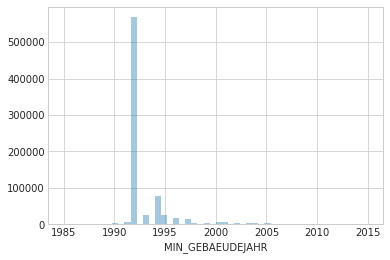

In [49]:
sns.distplot(azdias_cleaned_binary_encoded['MIN_GEBAEUDEJAHR'], hist=True, kde=False)
plt.show()

In [50]:
azdias_cleaned_binary_encoded['KBA13_ANZAHL_PKW'].value_counts()/azdias_cleaned_binary_encoded.shape[0]

1400.0    0.014744
1500.0    0.010400
1300.0    0.008072
1600.0    0.007707
1700.0    0.004772
1800.0    0.003283
417.0     0.002036
464.0     0.002027
519.0     0.002026
534.0     0.001887
386.0     0.001840
1900.0    0.001822
395.0     0.001821
481.0     0.001788
455.0     0.001778
452.0     0.001761
483.0     0.001759
454.0     0.001751
459.0     0.001746
450.0     0.001746
494.0     0.001745
418.0     0.001744
492.0     0.001718
504.0     0.001694
420.0     0.001693
387.0     0.001691
506.0     0.001679
388.0     0.001675
456.0     0.001675
439.0     0.001672
            ...   
27.0      0.000031
28.0      0.000029
25.0      0.000028
24.0      0.000028
18.0      0.000027
26.0      0.000027
17.0      0.000025
20.0      0.000023
21.0      0.000022
22.0      0.000020
14.0      0.000020
12.0      0.000020
29.0      0.000019
15.0      0.000017
23.0      0.000017
30.0      0.000015
19.0      0.000014
16.0      0.000013
13.0      0.000011
10.0      0.000010
1.0       0.000010
9.0       0.

# Re-encoding numeric variables

In [51]:
#re-encoding 'ANZ_PERSONEN': Number of adults in a household
azdias_cleaned_binary_encoded.loc[azdias_cleaned_binary_encoded['ANZ_PERSONEN']>5,
                                  'ANZ_PERSONEN']=0


In [52]:
#Re-encoding ANZ_TITEL: Number of professiona academic title holders ina household
#1 = no diplomas
#2 = having diplomas

azdias_cleaned_binary_encoded['ANZ_TITEL'].replace({0:1,1:2, 2:2, 3:2, 4:2}, inplace=True)

In [53]:
#re-encoding 'ANZ_HAUSHALTE_AKTIV'
#values of 30 will be considered as 0, or missing values.
azdias_cleaned_binary_encoded.loc[azdias_cleaned_binary_encoded['ANZ_HAUSHALTE_AKTIV']>30,
                                  'ANZ_HAUSHALTE_AKTIV']=0

In [54]:
### Re-encoding MIN_GEBAEUDEJAHR:
def Encode_Year(x):
    if x < 1992 or x >1997:
        return 0
    else:
        return x

azdias_cleaned_binary_encoded['MIN_GEBAEUDEJAHR'] = azdias_cleaned_binary_encoded['MIN_GEBAEUDEJAHR'].apply(Encode_Year) 

In [55]:
#Droping some numeric features & renaming the data set to df for brevity
numeric_drop=['ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW']

azdias_cleaned_binary_encoded.drop(columns=numeric_drop, axis='columns', inplace=True)

In [56]:
"""PERSONAL COMMENT: Before finaly filling in the NaN's, I will create a column
with the percentage of missing values in each row. Maybe this could retain some useful
information down the line, rather than removing them"""

azdias_cleaned_binary_encoded['%_Missing_values'] = azdias_cleaned_binary_encoded.isna().mean(axis= 1)


In [57]:
#Here I'll substitute all missing values as 0

azdias_cleaned_binary_encoded =azdias_cleaned_binary_encoded.fillna(0)

In [58]:
azdias_cleaned_binary_encoded = pd.get_dummies(azdias_cleaned_binary_encoded,
                                              columns = ['ANZ_PERSONEN', 'ANZ_TITEL',
                                                        'ANZ_HAUSHALTE_AKTIV',
                                                'MIN_GEBAEUDEJAHR',],
                                              prefix='NUM_FEAT')

In [59]:
# Lastly, I'll renaming the data set to df for brevity for future dimensionality reduction
df = azdias_cleaned_binary_encoded

df.shape

(785761, 115)

In [60]:
df.columns

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       ...
       'NUM_FEAT_28.0', 'NUM_FEAT_29.0', 'NUM_FEAT_30.0', 'NUM_FEAT_0.0',
       'NUM_FEAT_1992.0', 'NUM_FEAT_1993.0', 'NUM_FEAT_1994.0',
       'NUM_FEAT_1995.0', 'NUM_FEAT_1996.0', 'NUM_FEAT_1997.0'],
      dtype='object', length=115)

### Discussion 2.1: Apply Feature Scaling

First, an inspection of that the numeric features actually represent.

ANZ_PERSONEN: is the number of adults in a household. Therefore, this cannot be considered a continuous feature. From the distribution plot, we can see that there are negative numbers and excessively high number like 37 and higher, which makes no sense. Households with 1-5 adults represent 95% of the variance in the data set; therefore, I’ll replace any value larger than 5 to 0. and consider them as NaN.

ANZ_TITEL: Number of professional academic title holders in household. There are five uniquely different values and the values, 99% have no academic titles. I have chosen to recode this features as follows 0  as no diplomas, 1, 2, 3, 4 = 1 as having diplomas.

ANZ_HAUSHALTE_AKTIV: Number of households in the building. The feature as 291 uniquely different values. When investigating the distribution of values, we see that buildings with 1-30 households per building or over represent ~95% of the data set. So I’ll re-encode the values over 30 to represent a missing values such as 0.

ANZ_HH_TITEL: Number of professional academic title holders in building. As we can see from cell 46, as much as 96% of the entries are 0, no diplomas. This seems awfully similar to the ANZ_TITEL. I decided to drop this feature because it most likely won’t render much more information than the ANZ_TITEL feature. 

MIN_GEBAEUDEJAHR: This feature contains years. Thus is should be considered as a categorical variable. It contains 31 uniquely different values; however, the years 1992, 1993, 1995, 1995, 1996, 1997 account for ~93 of the data. Therefore, buildings constructed before 1992 and after 1997 will be recoded as 0, for missing values. The remaining will be re-encoded with hot-one encoding.

KBA13_ANZAHL_PKW: Number of cars in the PLZ8 region. This feature also makes no sense. There’re 1261 uniquely different values in the feature. So, I’ve decided to drop this feature too. 

After careful investigation of the six features that are considered numeric, I have decided to drop three of them; namely, 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW' as explained above. The remaining three cannot be considerd continous variables. For instance, MIN_GEBAEUDEJAHR contains years, which should be treated as categorical so I’ve re-encoded it. ANZ_HAUSHALTE_AKTIV are integers numbers of household per building. I have treated this feature as categorical and removed categories that hold very little variance and subsequently re-encode them. Similarly, ANZ_HH_TITEL was also treated as categorical variables and re-encoding and removal of entries that represented very little variance. As a result, none of the initially considered numeric features have been re-scaled as none of them could be considered continuous values. At least not as far as I could see. Lastly, no imputation was performed since imputing with the mean or mode for example would not make much sense since I don’t really see the “numeric” features as being continuous. In conclusion, no feature scalin, imputation was considered warranted.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca=PCA(n_components=115)
pca.fit(df)
df_pca = pca.transform(df)


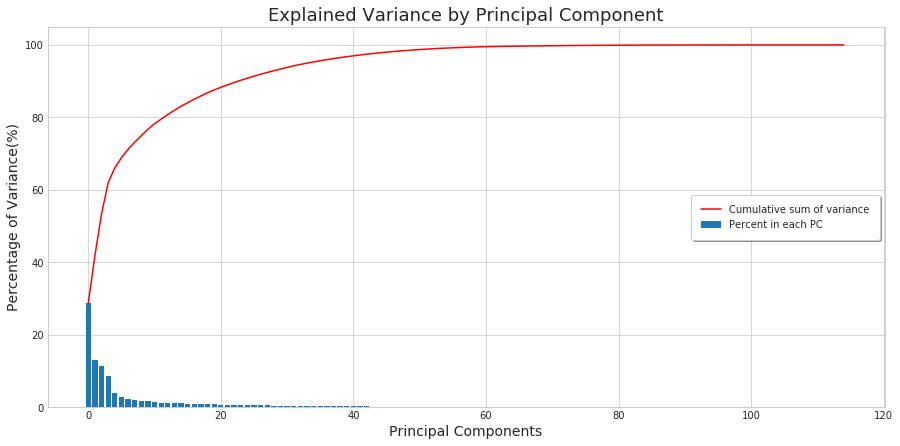

In [62]:
# Investigate the variance accounted for by each principal component.
n_components = np.arange(len(pca.explained_variance_ratio_))
variance = (pca.explained_variance_ratio_)*100
cuml_var = np.cumsum(variance)

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(n_components, variance, label='Percent in each PC')
ax.plot(n_components, cuml_var, c='r', label='Cumulative sum of variance')
ax.set_xlabel('Principal Components', size=14)
ax.set_ylabel('Percentage of Variance(%)', size=14)
ax.set_title('Explained Variance by Principal Component', size=18)
ax.legend(loc='center right', frameon=True, shadow=True, borderpad=1)
plt.show()

In [63]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_n15=PCA(n_components=15)
df_pcan15 = pca_n15.fit_transform(df)

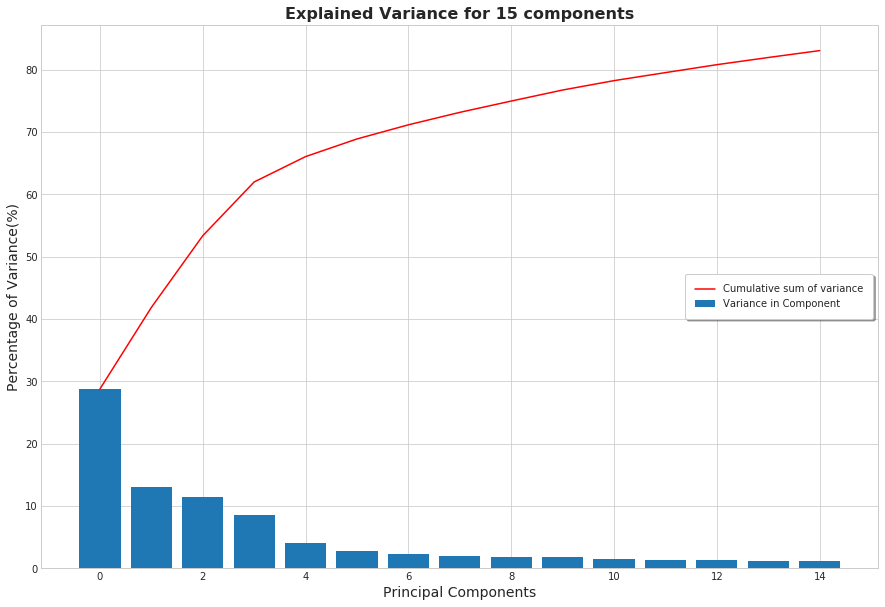

In [64]:
# Investigate the variance accounted for by each principal component.
length_comp = len(pca_n15.explained_variance_ratio_)
n15_components = np.arange(length_comp)
variance_n15 = (pca_n15.explained_variance_ratio_)*100
cuml_varn15 = np.cumsum(variance_n15)
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(n15_components, variance_n15, label='Variance in Component')
ax.plot(n15_components, cuml_varn15,c='r', label='Cumulative sum of variance')
ax.set_xlabel('Principal Components', size=14)
ax.set_ylabel('Percentage of Variance(%)', size=14)
ax.set_title('Explained Variance for 15 components', size=16,  fontweight='bold')
ax.legend(loc='center right',frameon=True, shadow=True, borderpad=1)
plt.show()

In [65]:
var = [round(i, 1) for i in variance_n15]
print('Variance captured by each Principal Component')

Variance captured by each Principal Component


### Discussion 2.2: Perform Dimensionality Reduction

As we can see from the 115 components, variance acumulation nears 100% with 60 components. The first 15 principal components explain more than 80% of the variance, with the first component capturing 29% of the variance, the second 13% of the variance, and so forth. So I'll continue with the first 15 components for the remainder of the analysis since this is a decent amount. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [66]:
Components_n15=pd.DataFrame(pca_n15.components_, columns=df.columns, index=['PC-1','PC-2','PC-3','PC-4', 'PC-5',
                                                                           'PC-6','PC-7','PC-8','PC-9','PC-10',
                                                                           'PC-11','PC-12','PC-13','PC-14','PC-15'])

In [67]:
#sns.pairplot(df_pca_n15)

In [68]:
Components_n15.head(15)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,NUM_FEAT_28.0,NUM_FEAT_29.0,NUM_FEAT_30.0,NUM_FEAT_0.0,NUM_FEAT_1992.0,NUM_FEAT_1993.0,NUM_FEAT_1994.0,NUM_FEAT_1995.0,NUM_FEAT_1996.0,NUM_FEAT_1997.0
PC-1,0.021724,0.002602,-0.034463,0.026602,-0.025089,-0.030013,0.025248,-0.007086,0.018850,-0.012430,...,0.000106,0.000132,0.000118,-0.000288,-0.001520,0.000614,0.002039,-0.000151,-0.000377,-0.000317
PC-2,-0.148623,-0.147234,0.204112,-0.168763,0.112392,0.146025,0.039942,0.015284,-0.076075,0.169973,...,0.000269,0.000280,0.000249,-0.001036,0.003010,0.000888,-0.000255,-0.000301,-0.001215,-0.001091
PC-3,-0.043532,0.109805,0.027826,-0.044725,0.063369,0.052583,-0.151855,0.012616,-0.069813,0.115631,...,-0.000508,-0.000470,-0.000436,0.005033,-0.011191,-0.001290,0.000205,0.001863,0.002823,0.002558
PC-4,0.109085,0.142554,-0.164779,0.150036,-0.224916,-0.140679,-0.000655,-0.010432,0.139768,0.250680,...,0.000159,0.000135,0.000124,-0.002862,0.005052,0.000516,0.000155,-0.000845,-0.000985,-0.001030
PC-5,-0.017119,0.145200,-0.041104,-0.004989,-0.113147,0.048726,-0.190151,0.021768,-0.010347,0.003899,...,-0.000313,-0.000289,-0.000281,0.008548,-0.004233,-0.001278,-0.005916,-0.000889,0.001229,0.002538
PC-6,0.026961,-0.081543,-0.012699,0.003883,-0.039492,-0.018200,0.104528,-0.009765,0.046111,-0.028504,...,0.000470,0.000430,0.000385,0.025202,-0.052266,0.001024,0.013775,0.004626,0.003681,0.003958
PC-7,-0.043473,0.057387,-0.151415,0.139820,-0.149146,-0.106734,0.092121,-0.076199,0.139363,-0.115799,...,-0.000164,-0.000193,-0.000218,-0.010802,0.015272,-0.000255,-0.002069,-0.000863,-0.000553,-0.000729
PC-8,-0.040294,-0.020534,-0.008772,0.002240,-0.044196,0.030558,0.041410,0.100043,-0.110472,0.055800,...,-0.000257,-0.000242,-0.000192,-0.001756,0.003562,0.000614,-0.000782,-0.000609,-0.000625,-0.000404
PC-9,0.043441,-0.040863,0.065823,-0.066101,0.048822,0.081041,0.018571,-0.103198,-0.007941,-0.079812,...,0.000357,0.000325,0.000370,0.005685,0.000181,-0.005450,-0.002814,0.000301,0.001264,0.000832
PC-10,0.073438,-0.071437,0.089528,-0.077881,0.041694,0.117390,0.054069,-0.116812,-0.106003,-0.045217,...,-0.000479,-0.000463,-0.000456,-0.013674,0.013710,0.003963,-0.000576,-0.000248,-0.001519,-0.001656


Text(0.5,1,'1st Principal Component')

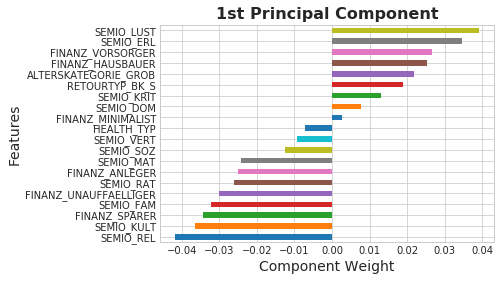

In [69]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
ax=Components_n15.iloc[0,0:20].sort_values(ascending=True).plot.barh()
ax.set_xlabel('Component Weight', size=14)
ax.set_ylabel('Features', size=14)
ax.set_title('1st Principal Component', size=16, fontweight='bold')

Text(0.5,1,'2nd Principal Component')

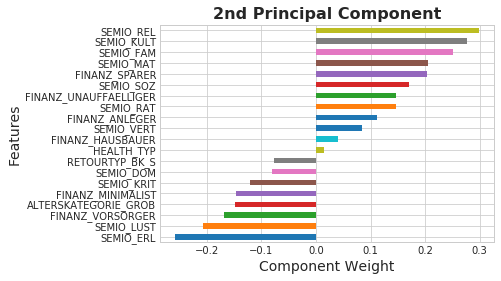

In [70]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

ax=Components_n15.iloc[1,0:20].sort_values(ascending=True).plot.barh()
ax.set_xlabel('Component Weight', size=14)
ax.set_ylabel('Features', size=14)
ax.set_title('2nd Principal Component', size=16, fontweight='bold')


Text(0.5,1,'3rd Principal Component')

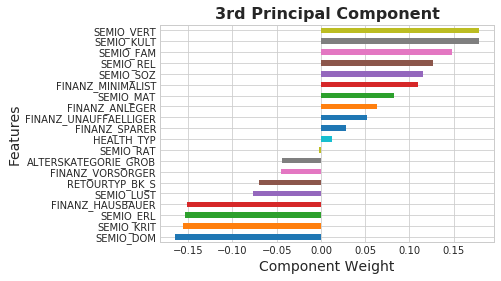

In [71]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
ax=Components_n15.iloc[2,0:20].sort_values(ascending=True).plot.barh()
ax.set_xlabel('Component Weight', size=14)
ax.set_ylabel('Features', size=14)
ax.set_title('3rd Principal Component', size=16, fontweight='bold')

### Discussion 2.3: Interpret Principal Components
(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

For the first 3 Principal Components, I investigated 20 features and the weights relative to each Principal Component. Broadly, the features that contains the highest amount of the variance in the data set can be broadly divided into four categories: 1) the age category(ALTERSKATEGORIE_GROB) , 2) Financial typologies (FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER), 3) Personality typologies (SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST), 4) Customer’s behavior with returning products (RETOURTYP_BK_S), and 5) HEALTH_TYP: 

The features that contains the highest amount of the variance in the data set can be broadly divided into four categories: 1) the age category(ALTERSKATEGORIE_GROB) , 2) Financial typologies (FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER), 3) Personality typologies (SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST), 4) Customer’s behavior with returning products (RETOURTYP_BK_S), and 5) HEALTH_TYP: 

The first Principal component has a positive corrlation with:
    1. SEMIO_LUST: sensual-minded
    2. SEMIO_ELR: Event-oriented
    3. FINANZ_VORSORGER: be prepared
    4. FINANZ_HAUSBAUER: home ownership
    5. ALTERSKATEGORIE_GROB:  Estimated age based on given name analysis
    6. RETOURTYP_BK_S: Customer’s product returning habits
    7. SEMIO_KRIT: critical-minded
    8. SEMIO_DOM: dominant-minded
    9. FINANZ_MINIMALIST: Low financial interest


The first Principal component has a negative corrlation with:
    10. HEALTH_TYPE: Health typology
    11. SEMIO_VERT: dreamful
    12. SEMIO_SOZ: Socially minded
    13. SEMIO_MAT: Materialistic
    14. FINANZ_ANLEGER: Investor
    15. SEMIO_RAT: rational
    16. FINANZ_UNAUFFAELLIGER: INCOSPICUOUS
    17. SEMIO_FAM: family-minded
    18. FINANZ_SPARER: Money-saver
    19. SEMIO_KULT: cultural-minded
    20. SEMIO_REL: religious

The second Principal component has a positive correlation with:
    1. SEMIO_REL: religious
    2. SEMIO_KULT: cultural-minded
    3. SEMIO_FAM: family-minded
    4. SEMIO_MAT: Materialistic
    5. FINANZ_SPARER: Money-saver
    6. SEMIO_SOZ: Socially minded
    7. FINANZ_UNAUFFAELLIGER: INCOSPICUOUS
    8. SEMIO_RAT: rational
    9. FINANZ_ANLEGER: Investor
    10. SEMIO_VERT: dreamful
    11. FINANZ_HAUSBAUER: home ownership
    12. HEALTH_TYP: Health typology

The second Principal component has a negative corrlation with:
    13. RETOURTYP_BK_S: type of customer with returning goods
    14. SEMIO_DOM: dominant-minded
    15. SEMIO_KRIT: critical-minded
    16. FINANZ_MINIMALIST: Low financial interest
    17. ALTERSKATEGORIE_GROB:  Estimated age based on given name analysis
    18. FINANZ_VORSORGER: be prepared
    19. SEMIO_LUST
    20. SEMIO_ERL


The third Principal component has a positive corrlation with:
    1. SEMIO_VERT: dreamful
    2. SEMIO_KULT: cultural-minded
    3. SEMIO_FAM: family-minded
    4. SEMIO_REL: religious
    5. SEMIO_SOZ: Socially minded
    6. FINANZ_MINIMALIST: Low financial interest
    7. SEMIO_MAT: Materialistic
    8. FINANZ_ANLEGER: Investor
    9. FINANZ_UNAUFFAELLIGER: INCOSPICUOUS
    10. FINANZ_SPARER: Money-saver
    11. HEALTH_TYP: Health typology

The third Principal component has a negative corrlation with:
    12. SEMIO_RAT: rational
    13. ALTERSKATEGORIE_GROB:  Estimated age based on given name analysis
    14. FINANZ_VORSORGER: be prepared
    15. RETOURTYP_BK_S: type of customer with returning goods
    16. SEMIO_LUST: sensual-minded
    17. FINANZ_HAUSBAUER: home ownership
    18. SEMIO_ERL: event-oriented
    19. SEMIO_KRIT: critical-minded
    20. SEMIO_DOM: dominant-minded

# Step 3: Clustering

## Step 3.1: Apply Clustering to General Population¶
You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
Then, compute the average difference from each point to its assigned cluster's center. Hint: The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [72]:
from sklearn.cluster import KMeans

In [73]:
"""# Over a number of different cluster counts...
from sklearn.cluster import KMeans

# Over a number of different cluster counts...
# run k-means clustering on the data and...
k_clusters=np.arange(3,21)
SSE_scores=[]
for k in k_clusters:
    kmeans = KMeans(n_clusters=k, n_jobs=-1)
    model = kmeans.fit(df_pca)
    # compute the average within-cluster distances.
    SSE_scores.append(np.abs(model.score(df_pca)))
    
    """

'# Over a number of different cluster counts...\nfrom sklearn.cluster import KMeans\n\n# Over a number of different cluster counts...\n# run k-means clustering on the data and...\nk_clusters=np.arange(3,21)\nSSE_scores=[]\nfor k in k_clusters:\n    kmeans = KMeans(n_clusters=k, n_jobs=-1)\n    model = kmeans.fit(df_pca)\n    # compute the average within-cluster distances.\n    SSE_scores.append(np.abs(model.score(df_pca)))\n    \n    '

In [74]:
"""fig, ax = plt.subplots(figsize=(8,5))
sns.pointplot(k_clusters, SSE_scores, markers='o', linestyle='-')
ax.set_xlabel('K Clusters', size=14)
ax.set_ylabel('SSE Score', size=14)
ax.set_title('Elbow plot', size=18, fontweight='bold')
ax.grid(axis='both')
"""

"fig, ax = plt.subplots(figsize=(8,5))\nsns.pointplot(k_clusters, SSE_scores, markers='o', linestyle='-')\nax.set_xlabel('K Clusters', size=14)\nax.set_ylabel('SSE Score', size=14)\nax.set_title('Elbow plot', size=18, fontweight='bold')\nax.grid(axis='both')\n"

In [75]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_n15 = KMeans(n_clusters=15, n_jobs=-1)
model_n15 = kmeans_n15.fit(df_pca)

Text(0.5,1,'Count per Cluster in transformed PCA General Pop')

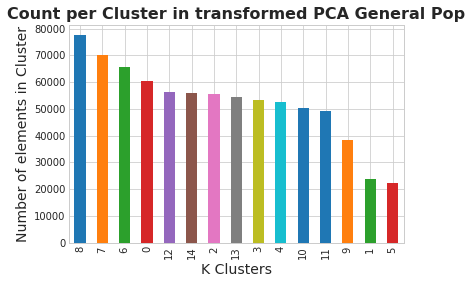

In [76]:
k_labels = pd.Series(model_n15.labels_)

ax=k_labels.value_counts().sort_values(ascending=False).plot.bar()
ax.set_xlabel('K Clusters', size=14)
ax.set_ylabel('Number of elements in Cluster', size=14)
ax.set_title('Count per Cluster in transformed PCA General Pop', size=16, fontweight='bold')

### Discussion 3.1: Apply Clustering to General Population

After plotting the elbow graph between SSE scores and K Clusters for 2-20 clusters, there was no obvious choice on how many clusters to choose, i.e. no elbow in the point plot. What that implies is that the clustering algorithm does not do a good job at finding the principal components, or dividing the data set into clear directions. However, this is not so obvious from the PC-Variance plot either. There the decision on the number of PC's was made based on the percentagem of variance, i.e. 80% of the variance. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [77]:
# Load in the customer demographics data.
azdias_cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';', na_values=na_mapping)


azdias_cust.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [78]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data

#Cleaning columns
CustColNa = azdias_cust.isnull().mean().sort_values(ascending=False)

col_drop =[]
for col, na_val in CustColNa.iteritems():
    if na_val >0.2:
        col_drop.append(col) 
        
azdias_cust.drop(columns=col_drop, axis='columns', inplace=True)       

# Cleaning rows
CustRowNa=azdias_cust.isnull().mean(axis=1).sort_values(ascending=False)

row_drop=[]
for index, na_row in CustRowNa.iteritems():
    if na_row >0.2:
        row_drop.append(index)
        
azdias_cust.drop(index=row_drop, inplace=True)   

#Dropping multilevel categorical attributes
azdias_cust.drop(columns=['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP', 'LP_STATUS_FEIN',
                         'LP_STATUS_GROB', 'ZABEOTYP'],axis='columns', inplace=True) 

#Encoding binary categorical attributes
azdias_cust = pd.get_dummies(azdias_cust, columns=['ANREDE_KZ', 'GREEN_AVANTGARDE'], 
                                              prefix='CAT-BIN')

"""PERSONAL COMMENT: all the mixed-type and numerica features that had to be
re-encoded, re-engineered, or drop in the demographics data set have already been
removed in the customer demographic data set for having over 20% of missing values"""

#Creating a missing values column
azdias_cust['%_Missing_values'] = azdias_cust.isna().mean(axis= 1)


#Filling in the NaN's with 0
azdias_cust.fillna(0, inplace=True)


In [79]:
azdias_cust.shape

(191559, 29)

In [80]:
# Running PCA general population model through the custumer data set

CustPCAModel = pca_n15.fit_transform(azdias_cust)

In [81]:
# obtain cluster predictions for the customer demographics data.

CustKmModel=kmeans_n15.fit(CustPCAModel)



Text(0.5,1,'Count per Cluster in transformed PCA Customer Data')

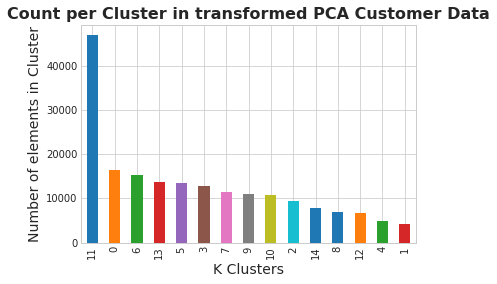

In [82]:
cust_k_labels = pd.Series(CustKmModel.labels_)

ax=cust_k_labels.value_counts().sort_values(ascending=False).plot.bar()
ax.set_xlabel('K Clusters', size=14)
ax.set_ylabel('Number of elements in Cluster', size=14)
ax.set_title('Count per Cluster in transformed PCA Customer Data', size=16, fontweight='bold')

In [83]:
cust_k_labels.shape[0]

191559

In [84]:
cust_label, count = np.unique(cust_k_labels, return_counts=True)

cust_count=count/cust_k_labels.shape[0]*100

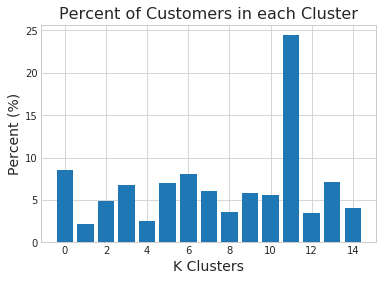

In [85]:
plt.bar(cust_label, cust_count)
plt.xlabel('K Clusters', size=14)
plt.ylabel('Percent (%)', size= 14)
plt.title('Percent of Customers in each Cluster', size=16)
plt.show()

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [86]:
#Figuring out the percent in each cluster of the Population Demographic data set
Pop_label, Pop_count = np.unique(k_labels, return_counts=True)

Pop_count_percent = Pop_count/k_labels.shape[0]*100

In [87]:
df_Count = pd.DataFrame({"Cluster":[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
                       "Count":[  7.91087863,   8.53940561,  24.42224067,   3.63177924,
         4.692027  ,   8.01737324,   5.55546855,   2.4927046 ,
         3.45011198,   6.94094248,   7.02446766,   2.40552519,
         3.10661467,   6.02007737,   5.79038312, 5.38280724,   3.01911141,   2.82121408,   9.88379418,
         6.89649906,   6.81377671,  10.84057366,   6.81912184,
         6.91037097,   7.32627351,   6.90718934,   8.6852109 ,
         6.58508121,   4.48456974,   6.62440615],
                       'Label':['Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics',
 'Customer Demographics', 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics',
 'Population Demographics'] })

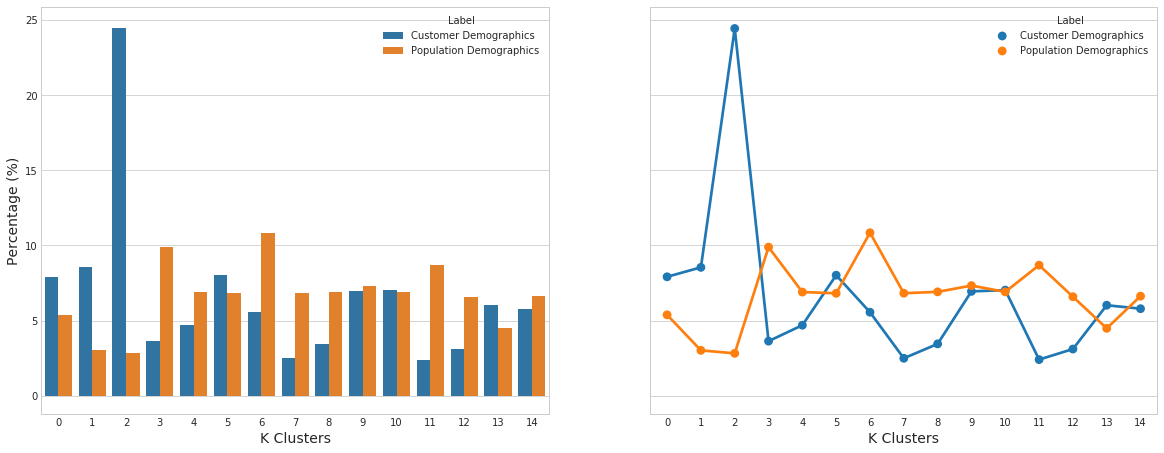

In [88]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7.5), sharey=True)
sns.barplot(ax=ax1, x='Cluster', y='Count', data=df_Count, hue='Label')
sns.pointplot(ax=ax2, x='Cluster', y='Count', data=df_Count, hue='Label')
ax1.set_xlabel('K Clusters', size=14)
ax2.set_xlabel('K Clusters', size=14)
ax1.set_ylabel('Percentage (%)', size=14)
ax2.set_ylabel('')
ax.set_title('Percentagem of Customers in each Cluster', size= 16)
plt.show()

In [89]:
Components_n15.columns[0:29]

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'KONSUMNAEHE', 'WOHNLAGE',
       'KBA05_ANTG1'],
      dtype='object')

In [90]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centers = pca_n15.inverse_transform(CustKmModel.cluster_centers_)

centers_df = pd.DataFrame(centers, columns=Components_n15.columns[0:29], 
                         index=['K-0','K-1','K-2', 'K-3', 'K-4', 'K-5',
                               'K-6','K-7', 'K-8', 'K-9', 'K-10',
                               'K-11','K-12', 'K-13', 'K-14'])

centers_df

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,KONSUMNAEHE,WOHNLAGE,KBA05_ANTG1
K-0,3.462493,4.928780,1.184576,4.789157,1.274074,1.670078,2.114825,4.010626,4.774590,4.192727,...,2.708778,2.960956,2.909482,2.495505,3.053315,0.984555,0.015445,0.350759,0.649241,0.001275
K-1,1.638267,3.106665,2.734749,3.505491,3.171868,2.948069,3.070652,3.029280,3.114837,3.750543,...,5.935801,6.035575,6.147131,3.788286,3.483635,0.243423,0.756577,0.812151,0.187849,0.001320
K-2,3.153541,4.262666,1.936767,4.061233,2.560235,2.517773,1.937963,2.986435,3.090081,1.928829,...,6.011904,3.605025,2.671147,2.106213,3.705930,0.092602,0.907398,0.432340,0.567660,0.003799
K-3,3.957519,3.036569,1.184660,4.901312,1.598994,1.468864,4.661662,4.142007,3.297113,2.142495,...,5.822303,2.252973,2.004541,5.199455,1.610485,0.021263,0.978737,0.851205,0.148795,0.001411
K-4,1.994063,4.041171,2.583403,3.577414,2.585613,2.884743,2.106594,3.451218,7.029150,6.977412,...,2.106046,5.916676,5.026889,3.255382,3.734182,1.262920,-0.262920,0.734762,0.265238,0.002346
K-5,3.545124,3.703401,1.225933,4.836515,1.099484,1.470565,3.880181,4.327652,4.886617,4.901132,...,2.346796,2.823281,2.983492,4.946819,2.130019,0.969399,0.030601,0.746691,0.253309,0.001077
K-6,2.932131,4.860918,1.460740,4.481835,1.523766,1.990392,1.811251,3.956110,4.519962,4.673751,...,3.065625,3.544609,3.964270,2.090562,3.370379,0.870422,0.129578,0.381903,0.618097,0.002854
K-7,3.841223,4.852698,1.123330,4.824216,1.013399,1.794166,2.436727,3.988630,4.933604,4.669223,...,1.664200,2.824752,3.921110,1.991184,3.069528,1.044044,-0.044044,0.201572,0.798428,0.002192
K-8,3.119526,3.938057,2.757139,3.322504,2.981106,3.223394,1.759269,2.990531,4.662137,4.802707,...,3.122261,3.552867,3.064955,3.612451,3.989894,0.934006,0.065994,0.655732,0.344268,0.001546
K-9,4.089107,4.978965,1.105999,4.925816,1.179194,1.887625,2.248600,4.099113,4.440124,4.427121,...,1.525314,2.260304,1.083968,1.992303,3.008825,1.077967,-0.077967,0.322965,0.677035,0.003105


Text(0.5,1,'Overrepresented: Cluster K-1')

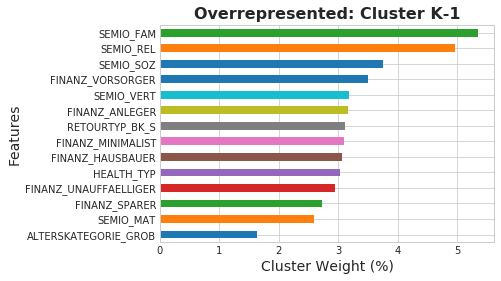

In [91]:
ax=centers_df.iloc[1,0:14].sort_values(ascending=True).plot.barh()
ax.set_xlabel('Cluster Weight (%)', size=14)
ax.set_ylabel('Features', size=14)
ax.set_title('Overrepresented: Cluster K-1', size=16, fontweight='bold')

Text(0.5,1,'Overrepresented: Cluster K-2')

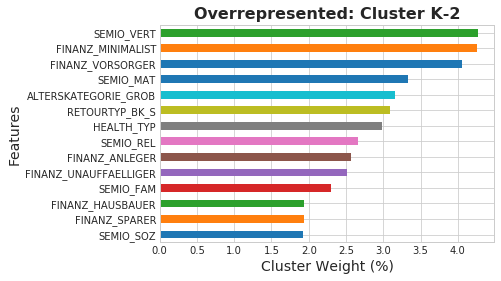

In [92]:
ax=centers_df.iloc[2,0:14].sort_values(ascending=True).plot.barh()
ax.set_xlabel('Cluster Weight (%)', size=14)
ax.set_ylabel('Features', size=14)
ax.set_title('Overrepresented: Cluster K-2', size=16, fontweight='bold')

Text(0.5,1,'Underrepresented: Cluster K-11')

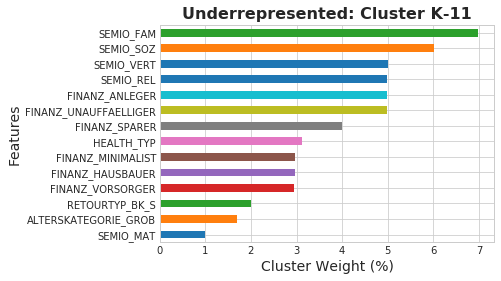

In [93]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

ax=centers_df.iloc[11,0:14].sort_values(ascending=True).plot.barh()
ax.set_xlabel('Cluster Weight (%)', size=14)
ax.set_ylabel('Features', size=14)
ax.set_title('Underrepresented: Cluster K-11', size=16, fontweight='bold')

Text(0.5,1,'Underrepresented: Cluster K-6')

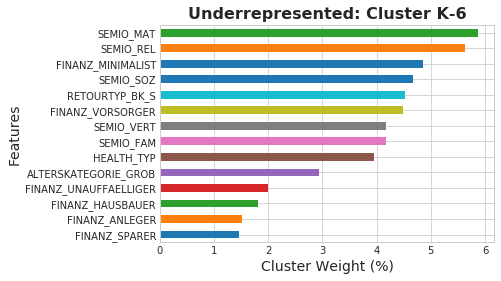

In [94]:
ax=centers_df.iloc[6,0:14].sort_values(ascending=True).plot.barh()
ax.set_xlabel('Cluster Weight (%)', size=14)
ax.set_ylabel('Features', size=14)
ax.set_title('Underrepresented: Cluster K-6', size=16, fontweight='bold')

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.